### **Phase 1: Load and Clean Dataset**

In [31]:
# Step 1: Upload Dataset
from google.colab import files
uploaded = files.upload()


Saving online_retail_II.xlsx to online_retail_II (1).xlsx


In [37]:
# Step 2: Load Both Sheets (2009-2010 and 2010-2011)

# Import python library
import pandas as pd

# Load both sheets
df_2009 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_2010 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')


In [38]:
# Step 3: Combine both sheets
df = pd.concat([df_2009, df_2010], ignore_index=True)


In [39]:
# Step 4: Show basic info
print("Shape:", df.shape)
df.head()


Shape: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [42]:
# Step 5: Clean the Dataset

# Drop rows with missing key fields
df.dropna(subset=['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price'], inplace=True)

# Remove canceled invoices (starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Keep only positive sales
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Add total sales value
df['Sales'] = df['Quantity'] * df['Price']

# Extract clean date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Date'] = df['InvoiceDate'].dt.date
df['Day'] = pd.to_datetime(df['Date'])

df.reset_index(drop=True, inplace=True)
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales,Date,Day
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,2009-12-01


In [43]:
# Step 6: Create Promotion Flag (Advanced Logic)

# Calculate average UnitPrice per product
avg_price = df.groupby('StockCode')['Price'].mean().rename('AvgPrice')
df = df.merge(avg_price, on='StockCode', how='left')

# Mark rows where price is <90% of average price as promotions
df['is_promoted'] = df['Price'] < (0.9 * df['AvgPrice'])

# Check sample
df[['StockCode', 'Price', 'AvgPrice', 'is_promoted']].head(10)


,StockCode,Price,AvgPrice,is_promoted
0,85048,6.95,9.221525,True
1,79323P,6.75,7.283910,False
2,79323W,6.75,7.030000,False
3,22041,2.10,3.540693,True
4,21232,1.25,1.531303,True
5,22064,1.65,2.141105,True
6,21871,1.25,1.726529,True
7,21523,5.95,8.912893,True
8,22350,2.55,3.097333,True
9,22349,3.75,4.155818,False


In [44]:
# Step 7: Save cleaned dataset
df.to_csv('cleaned_online_retail.csv', index=False)

In [45]:
# Step 8: Download it
from google.colab import files
files.download('cleaned_online_retail.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Phase 2: Analyze Promotion Impact Using XGBoost**

In [46]:
# Step 1: Load the Cleaned Dataset
import pandas as pd
df = pd.read_csv('cleaned_online_retail.csv')

In [47]:
# Step 2: Convert date again
df['Day'] = pd.to_datetime(df['Day'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales,Date,Day,AvgPrice,is_promoted
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12-01,2009-12-01,9.221525,True
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,2009-12-01,7.283910,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12-01,2009-12-01,7.030000,False
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009-12-01,2009-12-01,3.540693,True
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12-01,2009-12-01,1.531303,True


In [48]:
# Step 3: Aggregate Sales Per Day With Promotion Info

# Group daily sales WITH promotion flag
daily_df = df.groupby(['Day', 'is_promoted'])['Sales'].sum().unstack().fillna(0)

# Rename for clarity
daily_df.columns = ['No_Promo_Sales', 'Promo_Sales'] if 0 in daily_df.columns else ['Promo_Sales', 'No_Promo_Sales']

# Add Total Sales column
daily_df['Total_Sales'] = daily_df.sum(axis=1)

daily_df.head()


,Promo_Sales,No_Promo_Sales,Total_Sales
Day,,,
2009-12-01,21892.60,32620.90,54513.50
2009-12-02,19936.74,43415.77,63352.51
2009-12-03,18353.95,55683.96,74037.91
2009-12-04,14568.80,26164.12,40732.92
2009-12-05,2159.04,7644.01,9803.05


In [49]:
# Step 4: Feature Engineering for Time Series Model

# Basic time features
daily_df['dayofweek'] = daily_df.index.dayofweek
daily_df['month'] = daily_df.index.month

# Lag features to capture sales history
daily_df['lag_1'] = daily_df['Total_Sales'].shift(1)
daily_df['lag_7'] = daily_df['Total_Sales'].shift(7)
daily_df['lag_30'] = daily_df['Total_Sales'].shift(30)

# Drop early NaNs
daily_df.dropna(inplace=True)

daily_df.head()


,Promo_Sales,No_Promo_Sales,Total_Sales,dayofweek,month,lag_1,lag_7,lag_30
Day,,,,,,,,
2010-01-14,11346.020,20326.71,31672.730,3,1,22489.07,8746.18,54513.50
2010-01-15,2246.980,11268.91,13515.890,4,1,31672.73,73085.74,63352.51
2010-01-17,4292.330,13285.91,17578.240,6,1,13515.89,30319.05,74037.91
2010-01-18,10685.040,10766.52,21451.560,0,1,17578.24,23688.60,40732.92
2010-01-19,11190.521,22162.04,33352.561,1,1,21451.56,37887.26,9803.05


In [51]:
# Step 5: Train/Test Split

# Define features
features = ['dayofweek', 'month', 'lag_1', 'lag_7', 'lag_30', 'Promo_Sales']

# Target
target = 'Total_Sales'

# Split
train = daily_df[:-30]
test = daily_df[-30:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [52]:
# Step 6: Train XGBoost Regressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [53]:
# Step 7: Predict XGBoost Regressor
preds = model.predict(X_test)

In [54]:
# Step 8: Evaluate the Model

import numpy as np

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 14973.50
RMSE: 21012.31


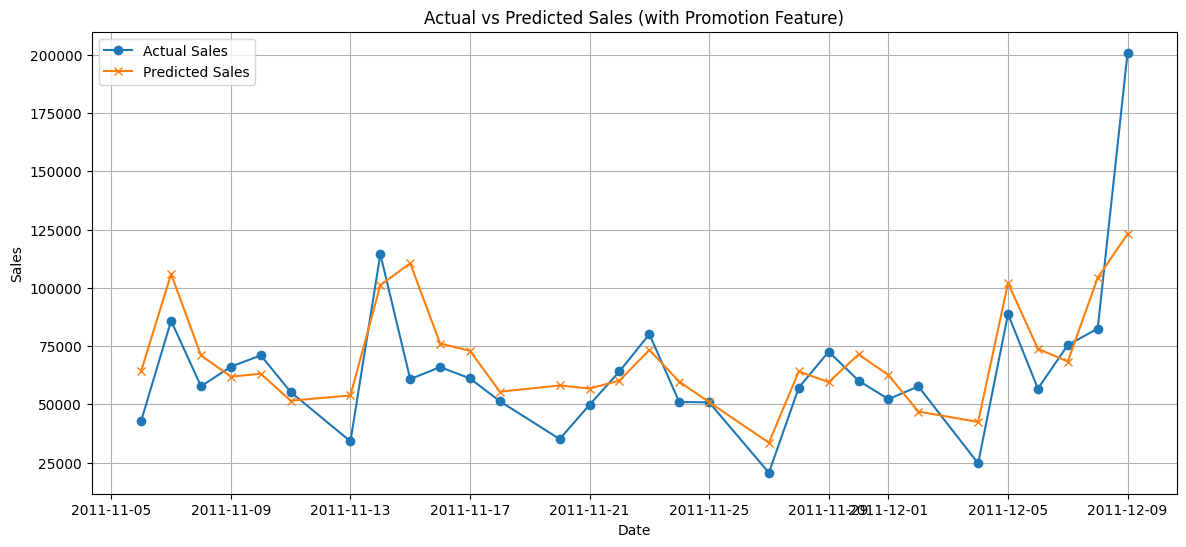

In [55]:
# Step 9: Visualize Predicted vs Actual Sales

import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual Sales', marker='o')
plt.plot(y_test.index, preds, label='Predicted Sales', marker='x')
plt.title('Actual vs Predicted Sales (with Promotion Feature)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()


### **Phase 3: Sales Uplift Analysis**

In [56]:
# Step 1: Train Model Without Promotion Feature

# Features WITHOUT promotion
features_wo_promo = ['dayofweek', 'month', 'lag_1', 'lag_7', 'lag_30']

# Train/test
X_train_wo = train[features_wo_promo]
X_test_wo = test[features_wo_promo]

# Train new model
model_wo = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_wo.fit(X_train_wo, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
# Step 2: Predict Model Without Promotion Feature
preds_wo = model_wo.predict(X_test_wo)

In [58]:
# Step 3: Evaluate Model Without Promotion Feature
mae_wo = mean_absolute_error(y_test, preds_wo)
rmse_wo = np.sqrt(mean_squared_error(y_test, preds_wo))

In [59]:
# Step 4: Compare With and Without Promotion

print("Model WITH Promotion Feature")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")

print("Model WITHOUT Promotion Feature")
print(f"MAE: {mae_wo:.2f}, RMSE: {rmse_wo:.2f}")


Model WITH Promotion Feature
MAE: 14973.50, RMSE: 21012.31

Model WITHOUT Promotion Feature
MAE: 23504.16, RMSE: 37985.07


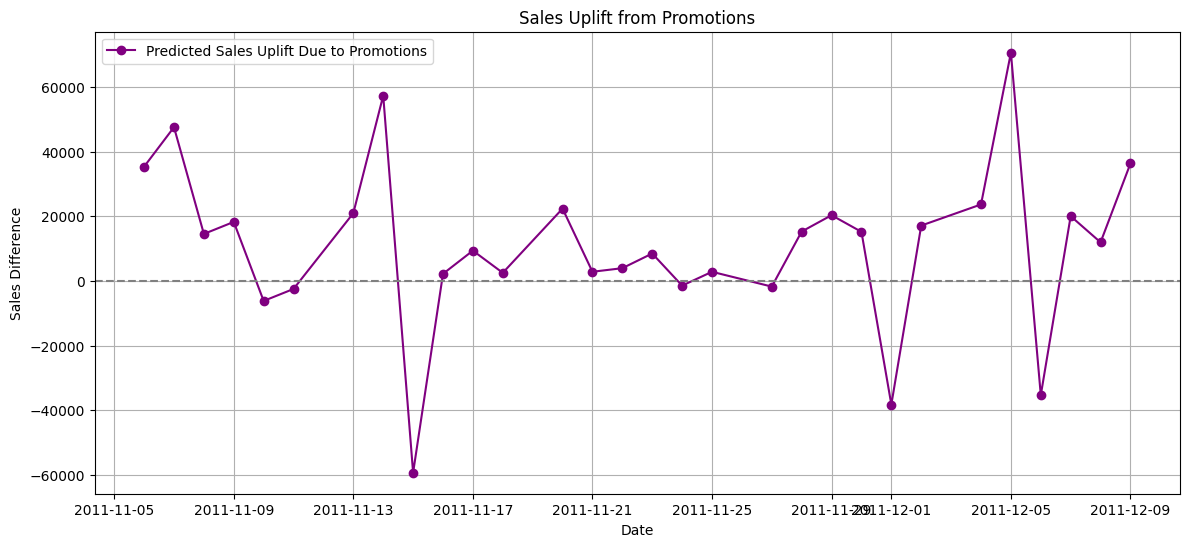

In [60]:
# Step 5: Visualize Uplift from Promotions

# Compare predictions side-by-side
compare_df = pd.DataFrame({
    'Actual': y_test,
    'Pred_with_promo': preds,
    'Pred_without_promo': preds_wo
})

compare_df['Uplift'] = compare_df['Pred_with_promo'] - compare_df['Pred_without_promo']

# Plot uplift
plt.figure(figsize=(14,6))
plt.plot(compare_df.index, compare_df['Uplift'], label='Predicted Sales Uplift Due to Promotions', color='purple', marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Sales Uplift from Promotions')
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.legend()
plt.grid()
plt.show()


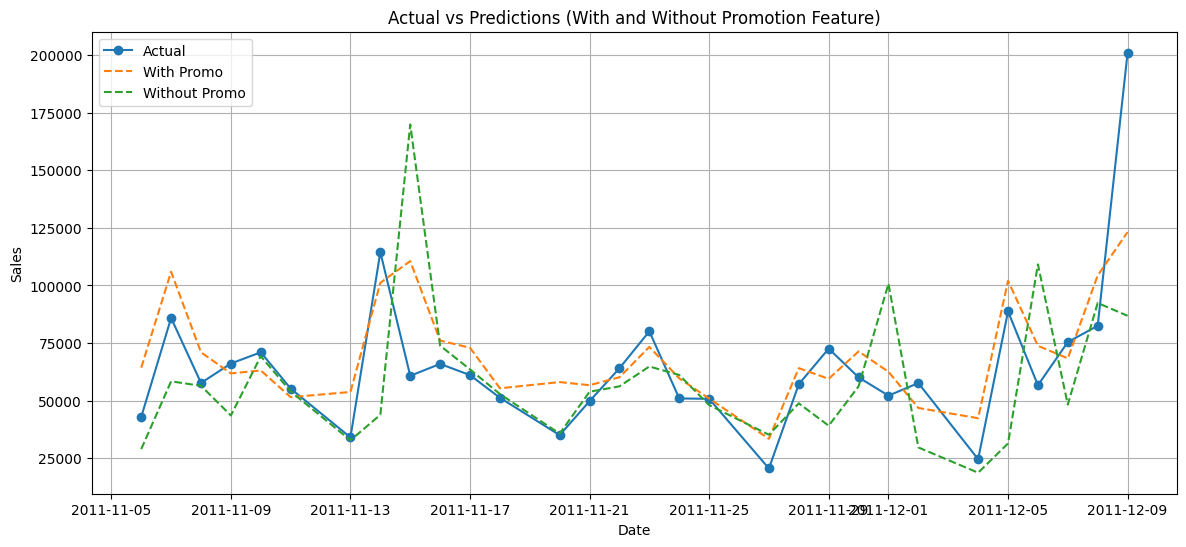

In [61]:
# Step 6: Visualize Actual vs Both Models

plt.figure(figsize=(14,6))
plt.plot(compare_df.index, compare_df['Actual'], label='Actual', marker='o')
plt.plot(compare_df.index, compare_df['Pred_with_promo'], label='With Promo', linestyle='--')
plt.plot(compare_df.index, compare_df['Pred_without_promo'], label='Without Promo', linestyle='--')
plt.title('Actual vs Predictions (With and Without Promotion Feature)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()
